In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn import metrics

In [57]:
df = pd.read_excel("train.xlsx")

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89082 entries, 0 to 89081
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](11), float64(59), int64(56), object(25)
memory usage: 102.6+ MB


In [61]:
df.duplicated().sum()

0

In [63]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130956066,NaN,3000,3000,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,130968727,NaN,5000,5000,5000.0,36 months,11.98,166.03,B,B5,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,130910225,NaN,7000,7000,7000.0,36 months,11.98,232.44,B,B5,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,130966492,NaN,30000,30000,30000.0,36 months,21.85,1143.39,D,D5,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,130942737,NaN,21000,21000,21000.0,60 months,20.39,560.94,D,D4,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


- Loại bỏ các feature định danh, không mang giá trị dự đoán: id, member_id, desc, title (purpose), url, zip_code, addr_state, grade, emp_title
- Loại bỏ các feature liên quan đến trạng thái sau khi vay: out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, next_pymnt_d, last_credit_pull_d, last_fico_range_high, last_fico_range_low
- Loại bỏ các feature liên quan đến khó khăn tài chính sau khi vay: hardship_flag, hardship_type, hardship_reason, hardship_status, deferral_term, hardship_amount, hardship_start_date, hardship_end_date, payment_plan_start_date, hardship_length, hardship_dpd, hardship_loan_status, orig_projected_additional_accrued_interest, hardship_payoff_balance_amount, hardship_last_payment_amount
- Loại bỏ feature liên quan đến giải quyết nợ: debt_settlement_flag, debt_settlement_flag_date, settlement_status, settlement_date, settlement_amount, settlement_percentage, settlement_term
- Loại bỏ feature có giá trị cố định hoặc không mang thông tin: policy_code, pymnt_plan, initial_list_status, disbursement_method

In [65]:
df = df[['annual_inc', 'emp_length', 'home_ownership', 'verification_status', 'loan_amnt', 'term', 'installment', 'sub_grade', 'purpose',
         'fico_range_high', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'avg_cur_bal', 'bc_open_to_buy', 'open_acc', 'pub_rec', 'bc_util','revol_bal', 
         'revol_util', 'total_acc', 'tot_cur_bal', 'earliest_cr_line', 'total_rev_hi_lim', 'acc_open_past_24mths', 'mort_acc',
         'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'loan_status']]

- Thông tin cá nhân:
    + annual_inc: Thu nhập hàng năm
    + emp_length: Thời gian làm việc
    + home_ownership: Tình trạng sở hữu nhà
    + verification_status: Trạng thái xác minh thu nhập
- Thông tin khoản vay:
    + loan_amnt: Số tiền vay
    + term: Thời hạn vay
    + installment: Số tiền trả góp hàng tháng
    + sub_grade: Cấp độ chỉ định mức vay chi tiết
    + purpose: Mục đích vay
- Thông tin tín dụng:
    + fico_range_high: Giới hạn trên của điểm FICO của người vay
    + dti: Tỷ lệ nợ trên thu nhập
    + delinq_2yrs: Số lần trả chậm trong 2 năm
    + avg_cur_bal: Số dư trung bình hiện tại của tất cả các tài khoản tín dụng
    + bc_open_to_buy: Số tiền tín dụng còn lại (khả dụng) trên các tài khoản thẻ tín dụng
    + inq_last_6mths: Số lần kiểm tra tín dụng trong 6 tháng
    + open_acc: Số tài khoản đang mở
    + pub_rec: Số hồ sơ công khai bất lợi
    + bc_util: Tỷ lệ sử dụng tín dụng trên các tài khoản thẻ tín dụng
    + revol_bal: Số dư tín dụng xoay vòng
    + revol_util: Tỷ lệ sử dụng tín dụng
    + total_acc: Tổng số tài khoản tín dụng
    + earliest_cr_line: Thời gian mở tài khoản tín dụng đầu tiên (có thể chuyển thành số năm tín dụng)
- Thông tin bổ sung:
    + tot_cur_bal: Tổng số dư hiện tại
    + total_rev_hi_lim: Tổng hạn mức tín dụng xoay vòng
    + acc_open_past_24mths: Số tài khoản mở trong 24 tháng qua
    + mort_acc: Số tài khoản thế chấp
    + pub_rec_bankruptcies: Số lần phá sản
    + tot_hi_cred_lim: Tổng hạn mức tín dụng

In [67]:
num_feature = ['annual_inc', 'loan_amnt', 'installment', 'fico_range_high', 'dti', 'delinq_2yrs', 'avg_cur_bal', 'bc_open_to_buy', 
               'inq_last_6mths', 'open_acc', 'pub_rec', 'bc_util', 'revol_bal', 'revol_util', 'total_acc', 'tot_cur_bal', 'total_rev_hi_lim',
               'acc_open_past_24mths', 'mort_acc', 'pub_rec_bankruptcies', 'tot_hi_cred_lim']
cat_feature = ['emp_length', 'home_ownership', 'verification_status', 'term', 'sub_grade', 'purpose']
date_feature = ['earliest_cr_line']

In [69]:
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df)) * 100

missing_data = pd.DataFrame({
    'feature': null_counts[null_counts > 0].index,
    'missing_count': null_counts[null_counts > 0].values,
    'missing_percent': null_percent[null_counts > 0].values
})
missing_data_sorted = missing_data.sort_values(by='missing_percent', ascending=False).reset_index(drop=True)

missing_data_sorted


,feature,missing_count,missing_percent
0,emp_length,6763,7.591882
1,bc_util,1371,1.539031
2,bc_open_to_buy,1326,1.488516
3,dti,177,0.198693
4,revol_util,86,0.096540
5,avg_cur_bal,5,0.005613


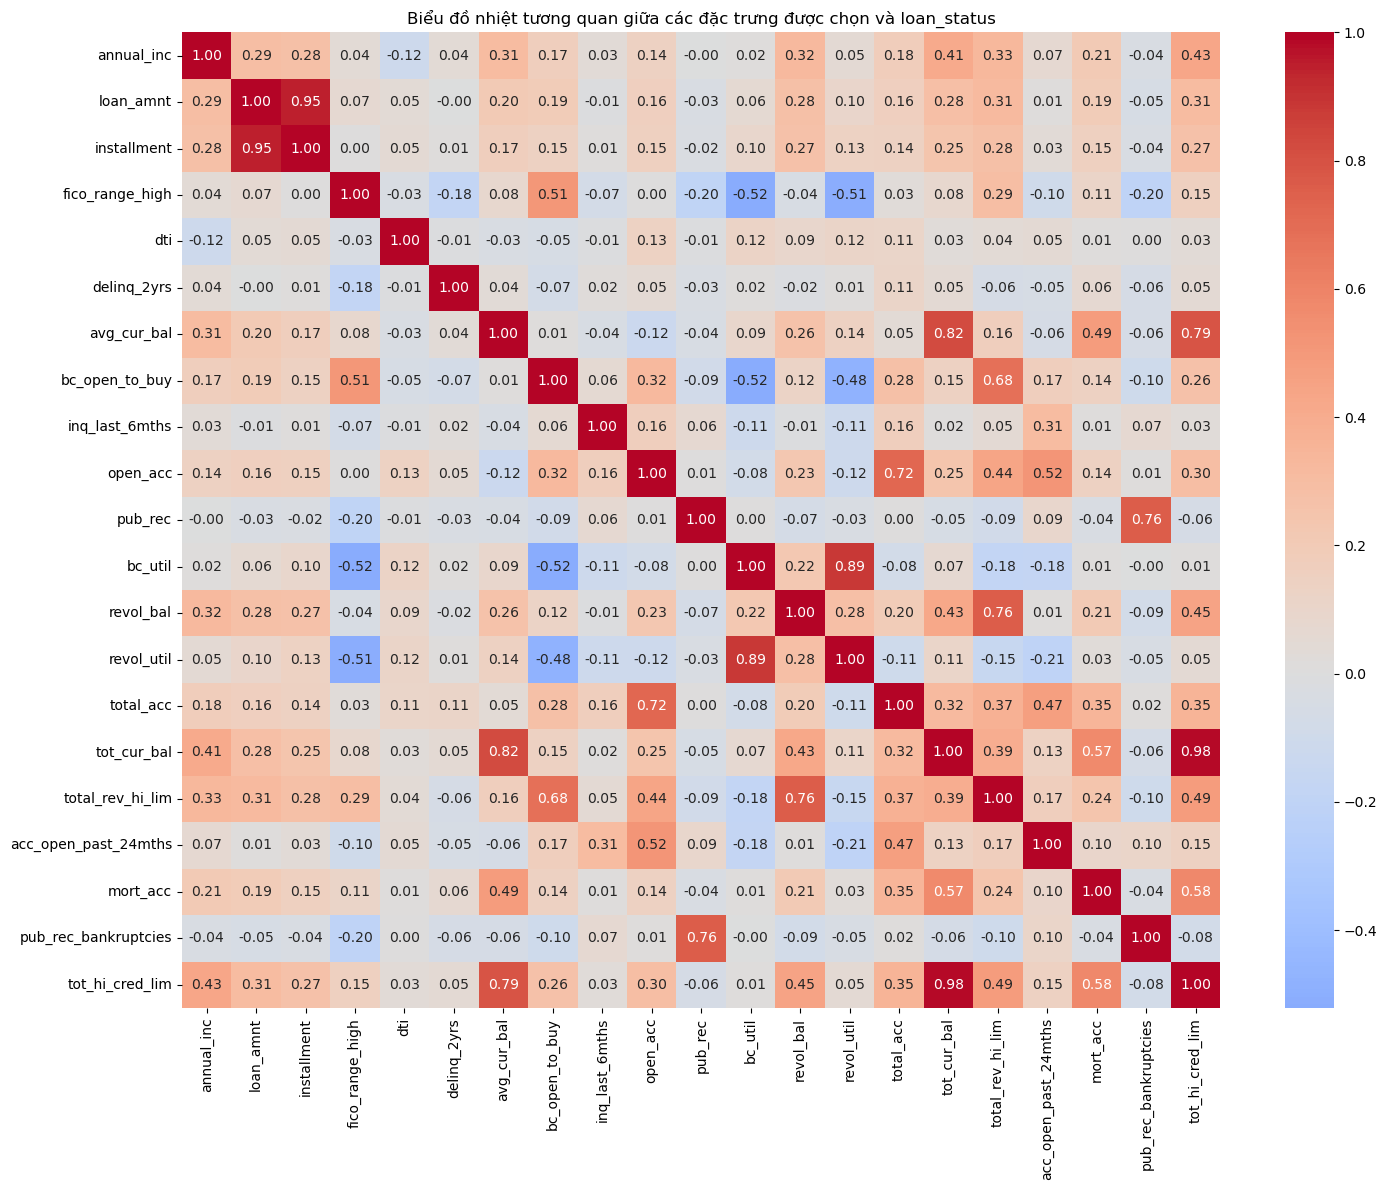

In [71]:
# Tính ma trận tương quan
corr_matrix = df[num_feature].corr()

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(15, 12))

# Tạo biểu đồ nhiệt
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')

# Đặt tiêu đề
plt.title('Biểu đồ nhiệt tương quan giữa các đặc trưng được chọn và loan_status')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

- Loại bỏ các cột có tương quan cao
    > Loại bỏ loan_amnt, tot_cur_bal, revol_bal, bc_util


In [74]:
df = df.drop(['loan_amnt', 'tot_cur_bal', 'revol_bal', 'bc_util'], axis = 1)

In [76]:
# Ánh xạ biến mục tiêu
loan_status_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1
}

df['loan_status'] = df['loan_status'].map(loan_status_mapping)

df['loan_status'].value_counts()

loan_status
0    70427
1    18655
Name: count, dtype: int64

- Fully Paid: Được trả hết toàn bộ, bao gồm cả gốc và lãi
- Charged Off: Khoản vay bị coi là không thể thu hồi, có nghĩa là người vay không trả được nợ trong một thời gian dài và bên cho vay quyết định ghi nhận khoản vay này là tổn thất
- Default: Trạng thái tiêu cực, hiếm gặp hơn Charged Off trong dữ liệu LendingClub, vì các khoản vay thường được chuyển sang Charged Off sau một thời gian nhất định
- debt_settlement_flag là thông tin sau khi khoản vay được cấp, liên quan đến việc xử lý nợ xấu. Nó không có sẵn tại thời điểm đánh giá đơn vay để quyết định chấp nhận hay không. Do đó, nó không phù hợp để sử dụng làm label hoặc feature trong bài toán dự đoán chấp nhận vay.

In [39]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder


# Tạo cột credit_years từ earliest_cr_line
df['credit_years'] = (pd.Timestamp.today() - df['earliest_cr_line']).dt.days / 365.25
df['credit_years'] = df['credit_years'].astype(float)

# Xóa cột earliest_cr_line vì đã chuyển thành credit_years
df = df.drop('earliest_cr_line', axis=1)

# Định nghĩa các danh sách cột
num_feature = ['annual_inc', 'installment', 'fico_range_high', 'dti', 'delinq_2yrs', 'avg_cur_bal', 'bc_open_to_buy', 
               'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'total_rev_hi_lim',
               'acc_open_past_24mths', 'mort_acc', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'credit_years']

ordinal_feature = ['sub_grade', 'emp_length', 'term']
nominal_feature = ['home_ownership', 'verification_status', 'purpose']

# Tạo transformer để xử lý tối thiểu
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))  # Điền giá trị trống bằng median
])
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Điền giá trị trống bằng giá trị phổ biến nhất
    ('encoder', OrdinalEncoder(categories=[
        ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 
         'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
        ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'],
        [' 36 months', ' 60 months']
    ]))
])

nom_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Điền giá trị trống bằng giá trị phổ biến nhất
    ('encoder', LabelEncoder())  # Sử dụng LabelEncoder cho từng cột nominal
])

# Tạo ColumnTransformer
preprocess = ColumnTransformer(transformers=[
    ('num_feature', num_transformer, num_feature),
    ('ordinal_feature', ord_transformer, ordinal_feature),
    ('nominal_feature', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Sử dụng OrdinalEncoder cho đơn giản
    ]), nominal_feature)
])

# Chuẩn bị dữ liệu
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Tạo pipeline với RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocess),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Huấn luyện mô hình
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['annual_inc', 'installment',
                                                   'fico_range_high', 'dti',
                                                   'delinq_2yrs', 'avg_cur_bal',
                                                   'bc_open_to_buy',
                                                   'inq_last_6mths', 'open_acc',
                                                   'pub_rec', 'revol_util',
                                                   'total_acc',
                                                   'total_rev_hi_lim',
                                                   'acc_open_past_24mths',
                                                   'mort_...
                                                                                               'months']]))]),
                                                  ['sub_grade', 'emp_length',
                                                   'term']),
                                                 ('nominal_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['home_ownership',
                                                   'verification_status',
                                                   'purpose'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

20 feature quan trọng nhất:
                 Feature  Importance
18             sub_grade    0.094455
1            installment    0.070749
3                    dti    0.067393
16       tot_hi_cred_lim    0.064979
10            revol_util    0.063702
6         bc_open_to_buy    0.063658
5            avg_cur_bal    0.063415
17          credit_years    0.060368
12      total_rev_hi_lim    0.060168
0             annual_inc    0.057114
2        fico_range_high    0.049554
11             total_acc    0.049116
8               open_acc    0.039988
13  acc_open_past_24mths    0.037125
19            emp_length    0.028554
23               purpose    0.022401
14              mort_acc    0.022206
7         inq_last_6mths    0.016492
22   verification_status    0.016113
20                  term    0.013872


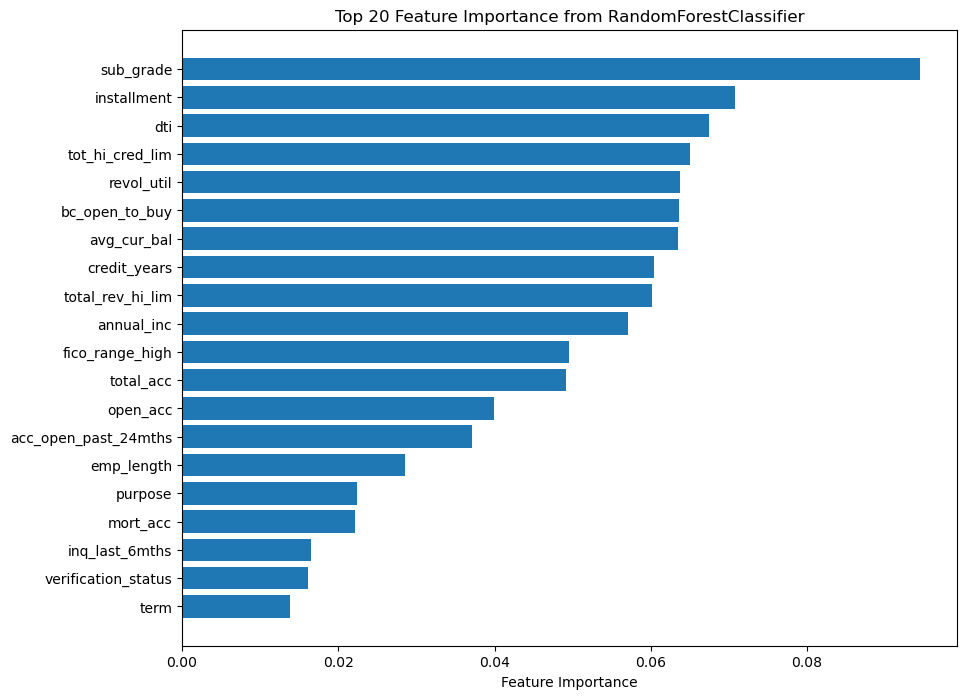

In [41]:
# Lấy feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Lấy tên feature sau khi qua preprocessor
feature_names = num_feature + ordinal_feature + nominal_feature

# Tạo DataFrame để lưu feature và importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sắp xếp theo importance giảm dần và lấy 20 feature quan trọng nhất
top_20_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

# In kết quả
print("20 feature quan trọng nhất:")
print(top_20_features)

# Vẽ biểu đồ feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance from RandomForestClassifier')
plt.gca().invert_yaxis()  # Đảo ngược trục y để feature quan trọng nhất ở trên cùng
plt.show()

In [43]:
feature_select = top_20_features['Feature'].tolist()

In [45]:
feature_select

['sub_grade',
 'installment',
 'dti',
 'tot_hi_cred_lim',
 'revol_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'credit_years',
 'total_rev_hi_lim',
 'annual_inc',
 'fico_range_high',
 'total_acc',
 'open_acc',
 'acc_open_past_24mths',
 'emp_length',
 'purpose',
 'mort_acc',
 'inq_last_6mths',
 'verification_status',
 'term']

# Numeric Feature

In [47]:
num_cols = [f for f in feature_select if df[f].dtype != "O"]
print(num_cols)

['installment', 'dti', 'tot_hi_cred_lim', 'revol_util', 'bc_open_to_buy', 'avg_cur_bal', 'credit_years', 'total_rev_hi_lim', 'annual_inc', 'fico_range_high', 'total_acc', 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'inq_last_6mths']


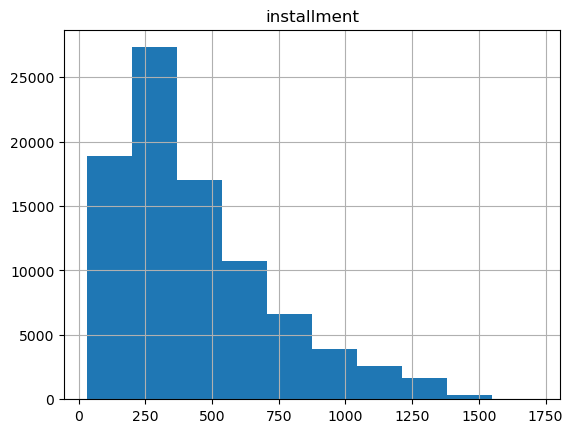

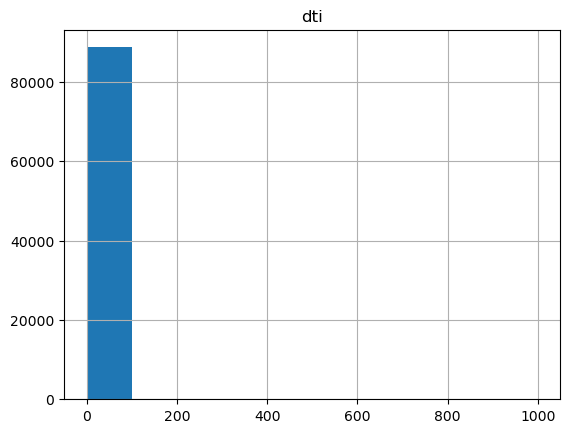

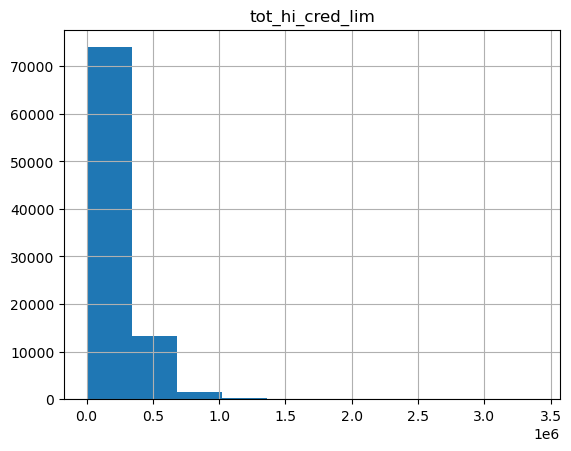

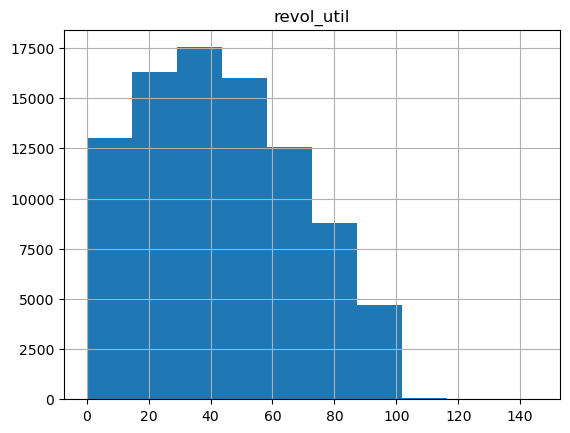

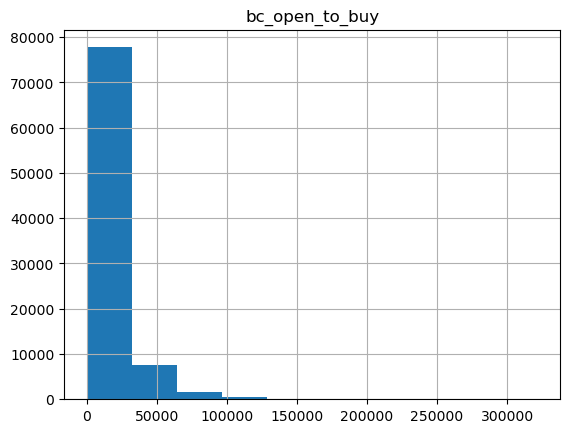

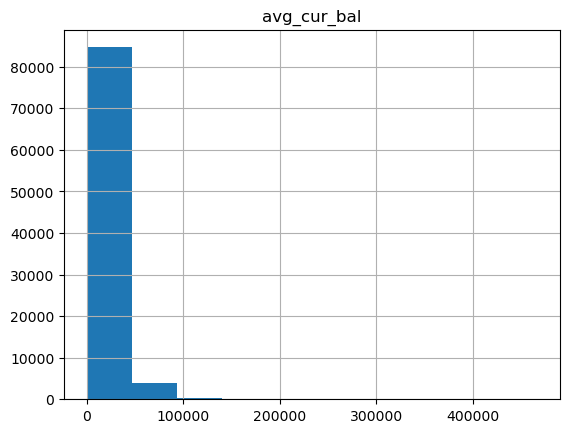

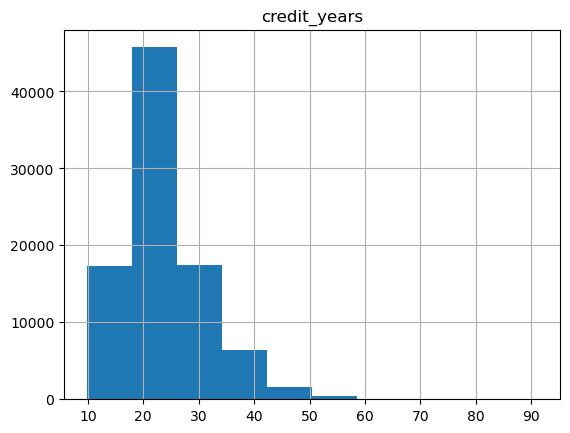

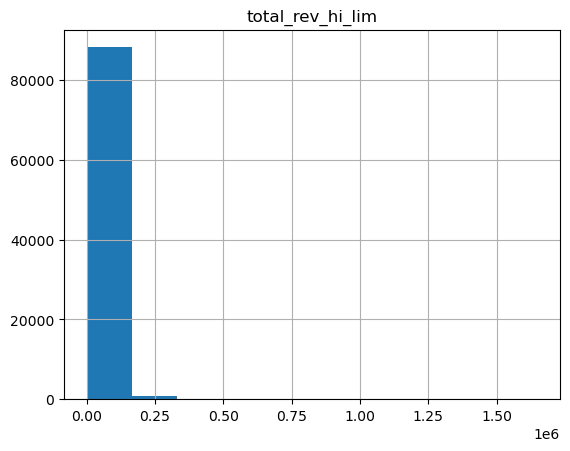

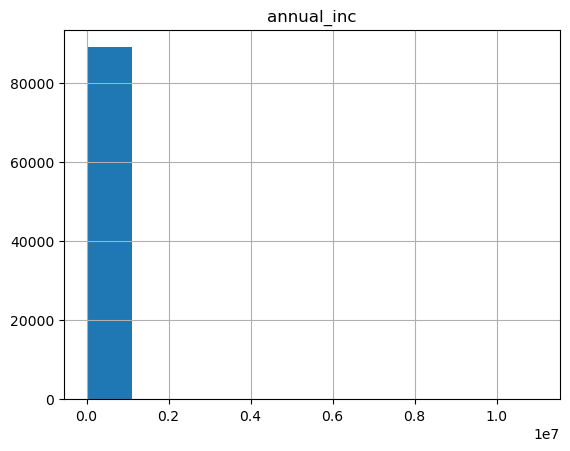

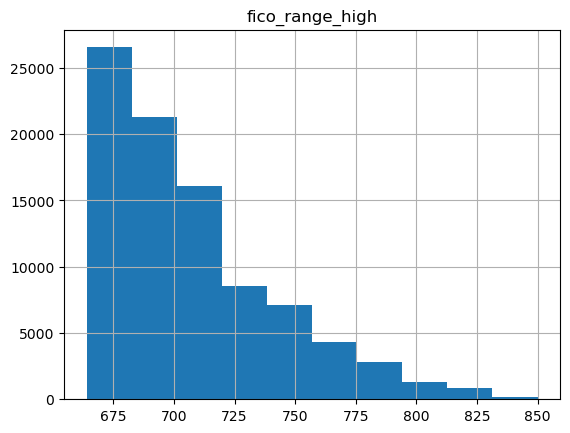

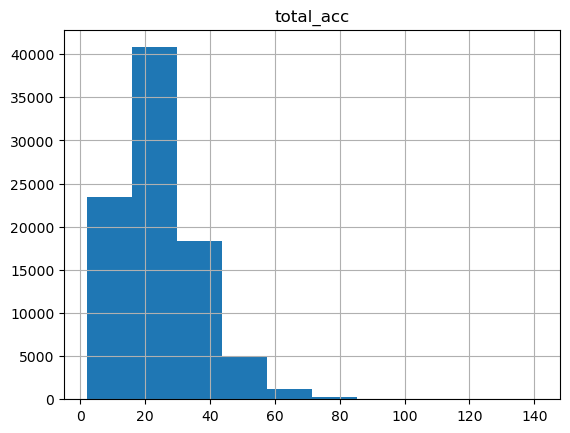

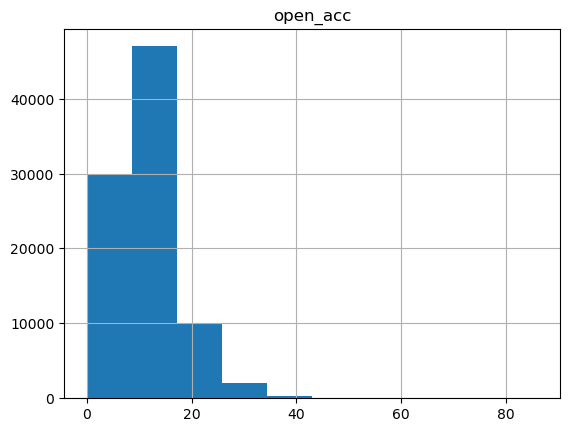

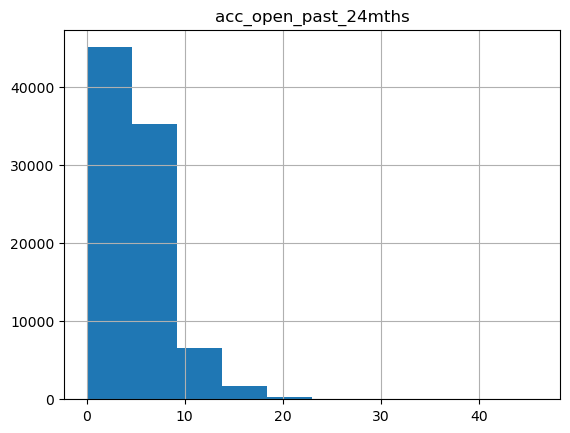

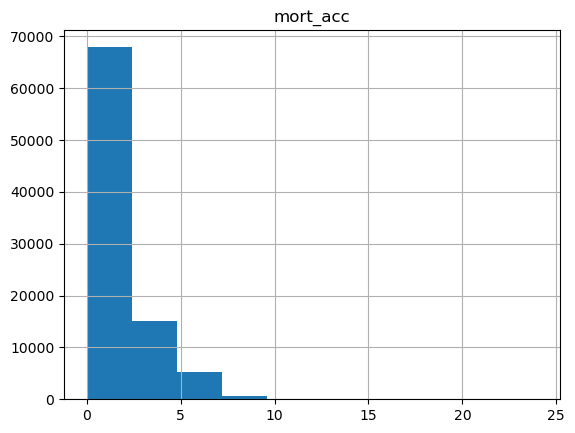

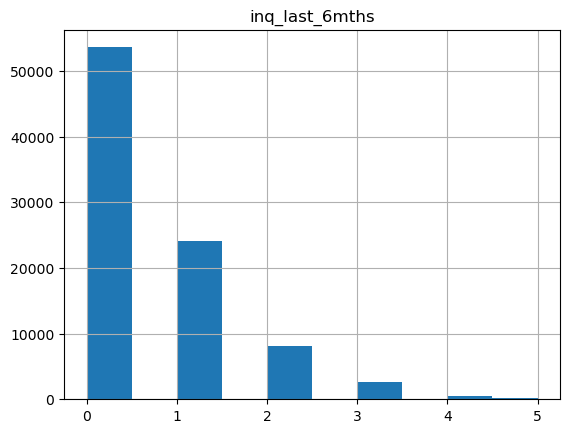

In [51]:
for col in num_cols:
    df[col].hist()
    plt.title(col)
    plt.show()

In [91]:
df['inq_last_6mths'].value_counts()

inq_last_6mths
0    53586
1    24055
2     8171
3     2594
4      484
5      192
Name: count, dtype: int64

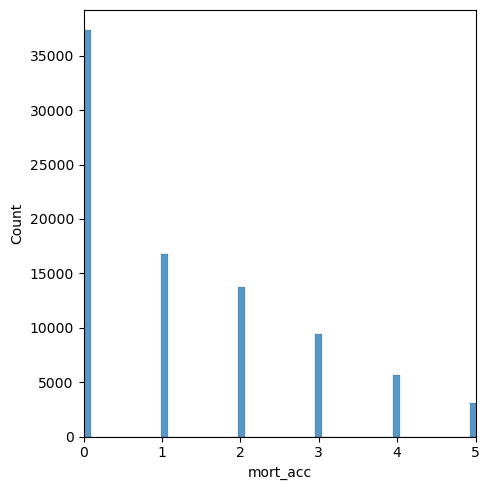

In [77]:
plt.figure(figsize = (5, 5))
sns.histplot(df, x = df['mort_acc'])
plt.xlim(0,5)
plt.tight_layout()
plt.show()

In [53]:
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=1)
variance_threshold.fit(df[num_cols])
print(variance_threshold.variances_)
print(variance_threshold.get_support())

[8.42652653e+04 3.90350297e+02 3.38884587e+10 6.44649020e+02
 3.44310147e+08 3.05302536e+08 5.74639798e+01 1.20426908e+09
 4.89608218e+09 1.29890711e+03 1.52552592e+02 3.37743446e+01
 1.17185393e+01 3.18196114e+00 7.11089145e-01]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False]


- ta thấy cột 'inq_last_6mths' có variance quá nhỏ thường chứa ít thông tin phân biệt -> loại bỏ

In [108]:
df = df.drop(['inq_last_6mths'], axis=1)

In [567]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Tìm median để thay thế outlier
    median = df[column].median()

    # Thay thế outlier bằng median
    df[column] = np.where(
        (df[column] < lower_bound) | (df[column] > upper_bound), median, df[column]
    )
    return df

# Xử lý outlier cho từng cột và lưu số lượng outlier
for col in num_feature:
    df = handle_outliers(df, col)

# Categorical Feature

In [49]:
object_cols = [f for f in feature_select if df[f].dtype == "O"]
print(object_cols)

['sub_grade', 'emp_length', 'purpose', 'verification_status', 'term']


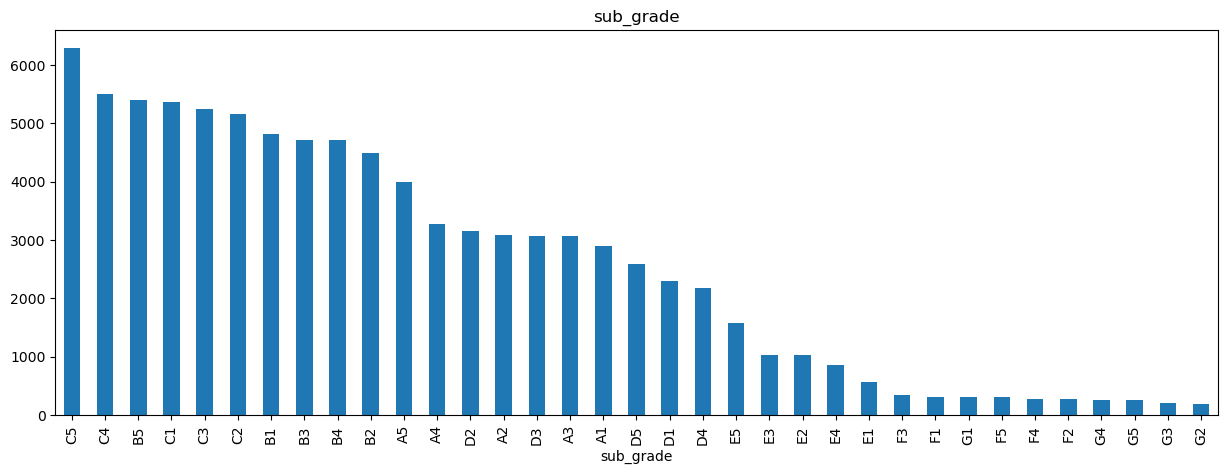

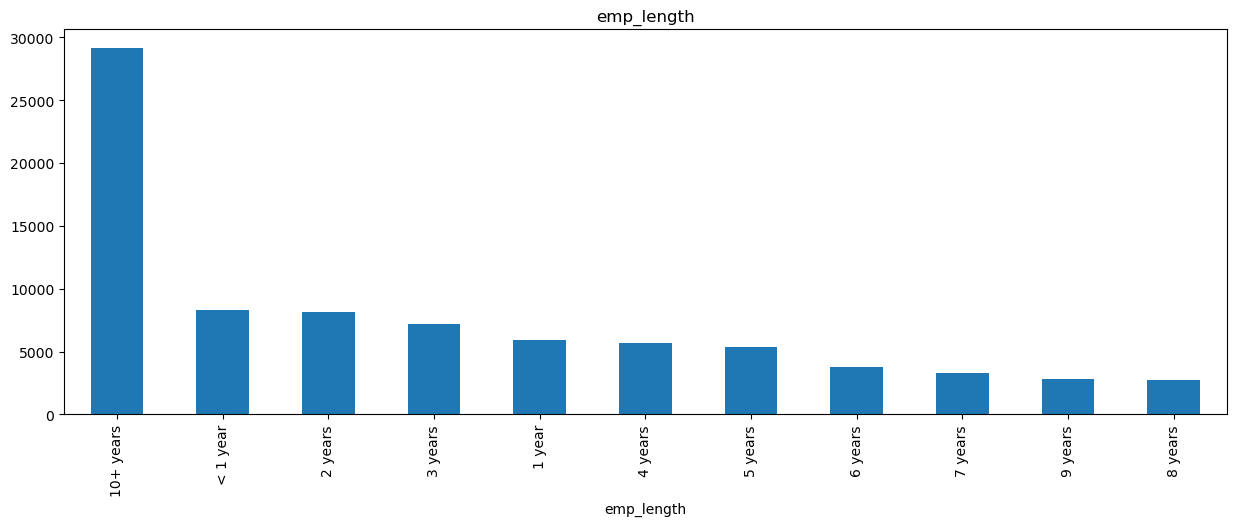

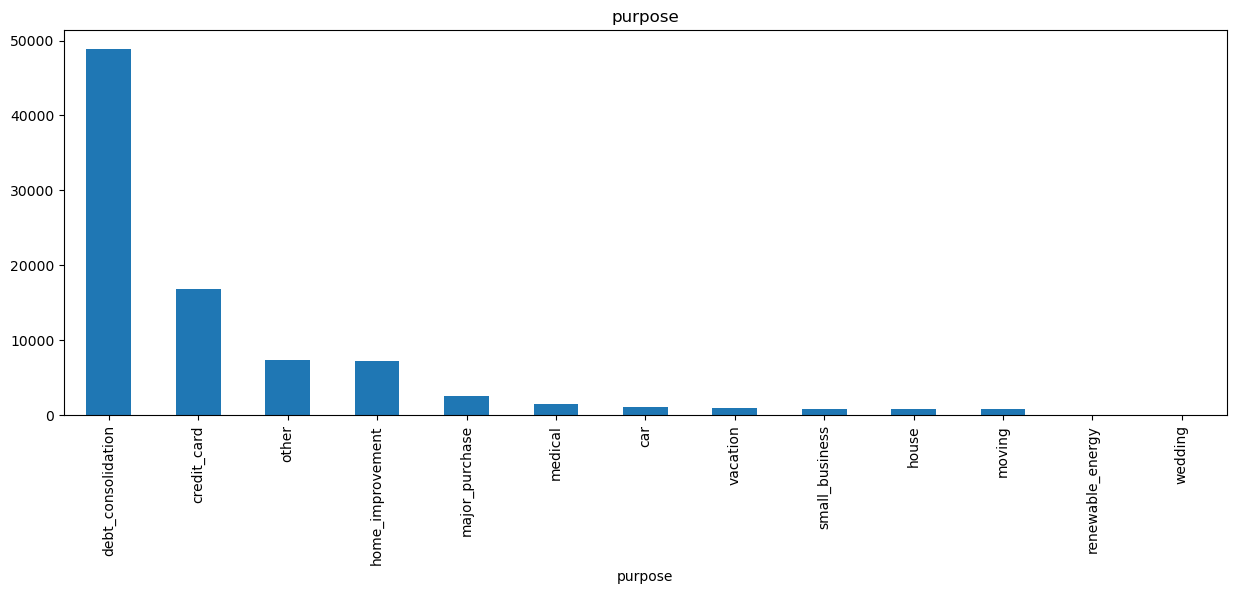

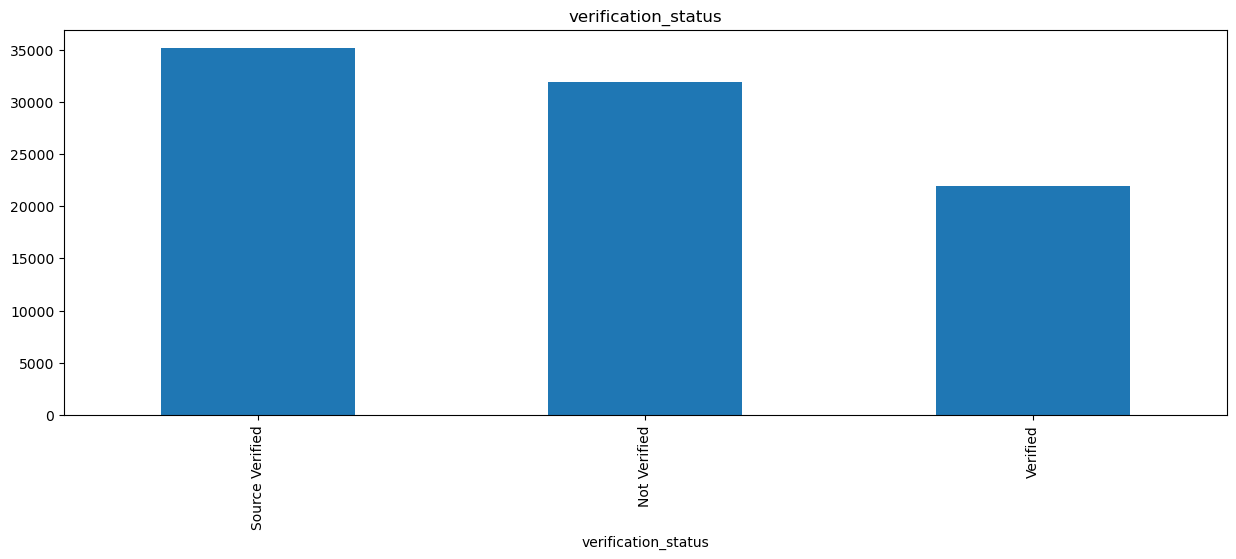

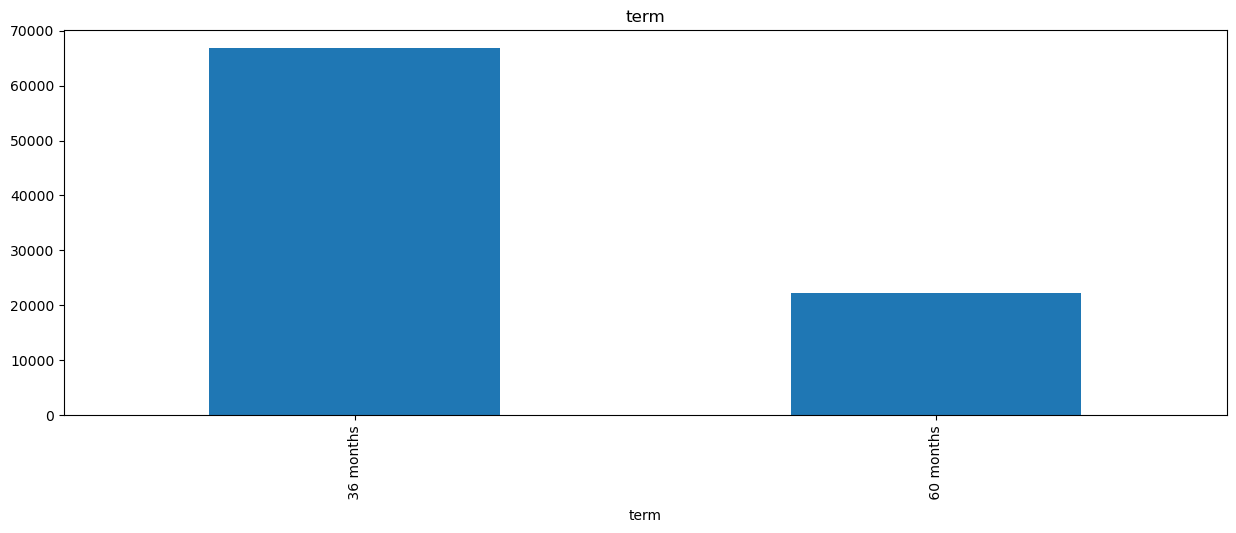

In [55]:
for col in object_cols:
    df[col].value_counts().plot(kind = 'bar', figsize = (15, 5))
    plt.title(col)
    plt.show()

In [110]:
df['purpose'].value_counts()

purpose
debt_consolidation    48931
credit_card           16818
other                  7342
home_improvement       7221
major_purchase         2528
medical                1504
car                    1131
vacation                961
small_business          882
house                   858
moving                  842
renewable_energy         62
wedding                   2
Name: count, dtype: int64

In [112]:
# Cột purpose
df.loc[df['purpose'].isin(['major_purchase', 'medical', 'car', 'vacation', 
                           'small_business', 'house', 'moving', 'renewable_energy', 'wedding']), 'purpose'] = 'Other'

In [99]:
term_values = {' 36 months': 36, ' 60 months': 60}
df['term'] = df.term.map(term_values)

In [82]:
df.head()

,annual_inc,emp_length,home_ownership,verification_status,term,installment,sub_grade,purpose,fico_range_high,dti,...,pub_rec,revol_util,total_acc,earliest_cr_line,total_rev_hi_lim,acc_open_past_24mths,mort_acc,pub_rec_bankruptcies,tot_hi_cred_lim,loan_status
0,52000.0,9 years,RENT,Source Verified,36 months,93.10,A4,major_purchase,764,0.58,...,0,0.5,30,1998-01-01,31000,3,4,0,191216,0
1,55000.0,10+ years,OWN,Not Verified,36 months,166.03,B5,other,679,14.18,...,1,33.9,24,2001-08-01,33800,2,0,1,61551,0
2,40000.0,< 1 year,MORTGAGE,Verified,36 months,232.44,B5,home_improvement,699,20.25,...,0,36.0,29,2007-03-01,13900,4,0,0,132817,0
3,57000.0,10+ years,OWN,Verified,36 months,1143.39,D5,debt_consolidation,684,27.58,...,0,53.2,26,2000-04-01,55500,5,2,0,188780,0
4,85000.0,10+ years,OWN,Source Verified,60 months,560.94,D4,house,669,15.76,...,0,34.2,27,2008-11-01,42700,8,3,0,172433,0


In [86]:
df['purpose'].value_counts()

purpose
debt_consolidation    48931
credit_card           16818
other                  7342
home_improvement       7221
major_purchase         2528
medical                1504
car                    1131
vacation                961
small_business          882
house                   858
moving                  842
renewable_energy         62
wedding                   2
Name: count, dtype: int64